# Age Classify Torch Conv2d

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '../input/womens-faces-sorted-by-age-from-18-to-70-years-old/train'
classes0 = os.listdir(data_dir)
classes=sorted(classes0)
print(len(classes))

53


In [3]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(60),             # resize shortest side
        transforms.CenterCrop(60),         # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 56890


In [5]:
# view one image shape of the dataset.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 60, 60])


In [6]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  18 (0)


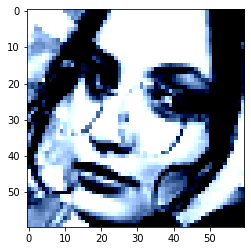

In [7]:
show_image(*dataset[50])

Label:  18 (0)


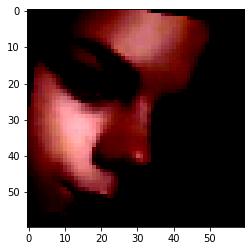

In [8]:
show_image(*dataset[100])

In [9]:
torch.manual_seed(10)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size - test_size

In [10]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)   

(39823, 5689, 11378)

In [11]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


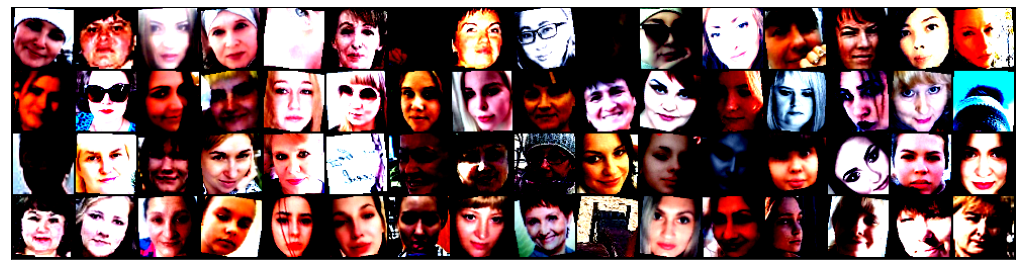

In [12]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
torch.cuda.is_available()

True

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [19]:
input_size = 3*60*60
output_size = 3

# Conv2d Model

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(12250, 64),  
            nn.ReLU(),            
            nn.Linear(64, 32),  
            nn.ReLU(),            
            nn.Linear(32, 16),           
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(8, 53))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12250, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [23]:
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12250, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [24]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 60, 60])
out.shape: torch.Size([64, 53])
out[0]: tensor([ 3.3725e-01, -6.9528e-04,  2.2234e-01, -1.8352e-01, -3.2907e-02,
         2.6774e-01,  1.9130e-01, -4.1756e-01, -1.3162e-01,  2.0363e-01,
        -3.6946e-01, -2.5148e-01, -5.1623e-01, -6.2210e-02,  1.7700e-01,
        -1.3783e-01, -1.1238e-01, -1.9119e-01, -3.5589e-01,  3.0297e-01,
         3.6776e-03,  2.4513e-03, -3.0115e-01, -1.0592e-01, -2.5374e-02,
        -1.0053e-01,  3.4665e-01,  2.0854e-01,  3.0018e-01, -3.0505e-01,
         1.4432e-01,  1.1430e-02,  2.6142e-01,  2.4893e-01,  2.8955e-01,
         3.5466e-01,  5.1834e-02,  1.2905e-02,  5.0309e-04, -1.6817e-02,
        -2.0651e-01,  1.7595e-01,  1.8257e-01, -4.3390e-01,  1.5888e-01,
        -1.8829e-03, -8.7221e-02, -3.3777e-01,  1.1329e-01, -2.6642e-01,
        -2.4785e-01,  6.7763e-02, -2.7282e-02], device='cuda:0',
       grad_fn=<SelectBackward>)


In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12250, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(CnnModel(), device)

In [29]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 3.9743402004241943, 'val_acc': 0.030424583703279495}]

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [31]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.4767, val_loss: 3.7548, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.7433, val_loss: 3.7532, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7414, val_loss: 3.7527, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.7406, val_loss: 3.7516, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.7396, val_loss: 3.7530, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.7399, val_loss: 3.7536, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.7401, val_loss: 3.7541, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.7400, val_loss: 3.7532, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.7402, val_loss: 3.7525, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.7398, val_loss: 3.7523, val_acc: 0.0394


In [32]:
history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)

  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.7385, val_loss: 3.7519, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.7380, val_loss: 3.7519, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7377, val_loss: 3.7518, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.7381, val_loss: 3.7519, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.7378, val_loss: 3.7518, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.7378, val_loss: 3.7518, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.7378, val_loss: 3.7519, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.7376, val_loss: 3.7519, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.7379, val_loss: 3.7520, val_acc: 0.0394


  0%|          | 0/623 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.7377, val_loss: 3.7520, val_acc: 0.0394


In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

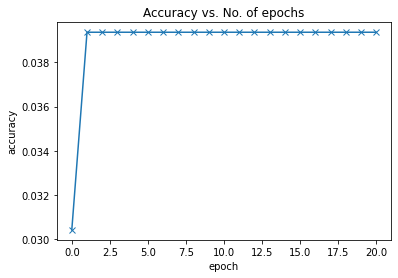

In [34]:
plot_accuracies(history)

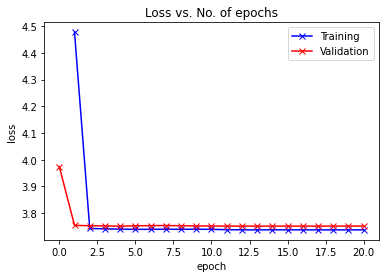

In [35]:
plot_losses(history)

In [36]:
evaluate(model, test_loader)

{'val_loss': 3.7372052669525146, 'val_acc': 0.04022521153092384}